In [1]:
import os, sys
from tqdm import trange

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn
from torch.utils.data import TensorDataset

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
    PointAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation

from model import Model

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

GPU available


In [2]:
## Generate data
input_dim, output_dim = 2, 2
NA = 9
NB = 9
NC = 1
ND = 1
sigma = 0.2

input_A = np.array([[1, 1]] * NA) + np.random.normal(0, sigma, size=(NA, 2))
output_A = np.array([[-1, 1]] * NA) + np.random.normal(0, sigma, size=(NA, 2))
names_A = [f"A{n}" for n in range(NA)]
data_A = TensorDataset(
    torch.from_numpy(input_A.astype(np.float32)).to(device),
    torch.from_numpy(output_A.astype(np.float32)).to(device),
)

input_B = np.array([[-1, -1]] * NB) + np.random.normal(0, sigma, size=(NB, 2))
output_B = np.array([[1, -1]] * NB) + np.random.normal(0, sigma, size=(NB, 2))
names_B = [f"B{n}" for n in range(NA)]
data_B = TensorDataset(
    torch.from_numpy(input_B.astype(np.float32)).to(device),
    torch.from_numpy(output_B.astype(np.float32)).to(device),
)

input_C = np.array([[1, 1]] * NC) + np.random.normal(0, sigma, size=(NC, 2))
output_C = np.array([[1, -1]] * NC) + np.random.normal(0, sigma, size=(NC, 2))
names_C = [f"C{n}" for n in range(NC)]
data_C = TensorDataset(
    torch.from_numpy(input_C.astype(np.float32)).to(device),
    torch.from_numpy(output_C.astype(np.float32)).to(device),
)

input_D = np.array([[-1, -1]] * ND) + np.random.normal(0, sigma, size=(ND, 2))
output_D = np.array([[-1, 1]] * ND) + np.random.normal(0, sigma, size=(ND, 2))
names_D = [f"D{n}" for n in range(ND)]
data_D = TensorDataset(
    torch.from_numpy(input_D.astype(np.float32)).to(device),
    torch.from_numpy(output_D.astype(np.float32)).to(device),
)

inputs = np.concatenate([input_A, input_B, input_C, input_D])
outputs = np.concatenate([output_A, output_B, output_C, output_D])
names = names_A + names_B + names_C + names_D

encoding = Encoding(dict(zip(names, inputs)))

# inputs = torch.from_numpy(inputs.astype(np.float32)).to(device)
# outputs = torch.from_numpy(outputs.astype(np.float32)).to(device)

# dataset = TensorDataset(inputs, outputs)
train_datasets = [data_A, data_B, data_C, data_D]
val_dataset = [data_A]

tracked_datasets = val_dataset + train_datasets

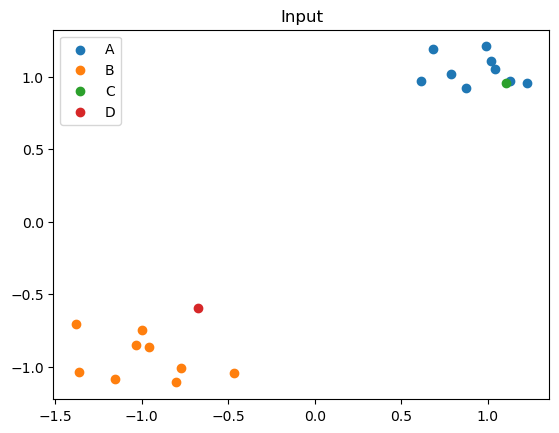

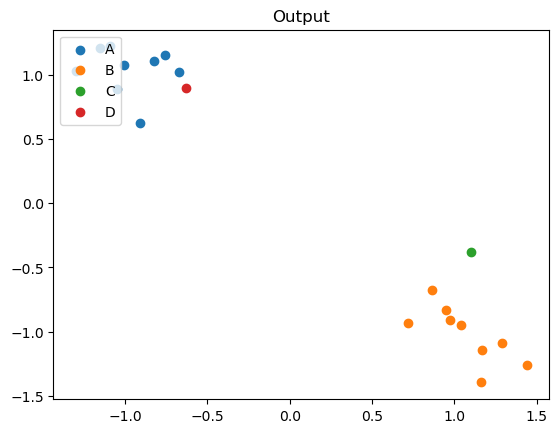

In [3]:
## Plot data
plt.scatter(input_A[:, 0], input_A[:, 1], label="A")
plt.scatter(input_B[:, 0], input_B[:, 1], label="B")
plt.scatter(input_C[:, 0], input_C[:, 1], label="C")
plt.scatter(input_D[:, 0], input_D[:, 1], label="D")
plt.legend(loc="upper left")
plt.title("Input")
plt.show()

plt.scatter(output_A[:, 0], output_A[:, 1], label="A")
plt.scatter(output_B[:, 0], output_B[:, 1], label="B")
plt.scatter(output_C[:, 0], output_C[:, 1], label="C")
plt.scatter(output_D[:, 0], output_D[:, 1], label="D")
plt.legend(loc="upper left")
plt.title("Output")
plt.show()

In [4]:
gain = 2.2
P = 50
L = 20

In [5]:
## Instantiate model
model = Model(
    encoding=encoding,
    input_size=inputs.shape[1],
    output_size=outputs.shape[1],
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
)

In [6]:
## AMSGRAD

In [7]:
## Setup compiler

# Define hyperparameters
n_epochs = 50000
lr = 0.0002 / P

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model, lambda inputs: model(inputs)[1][int(len(model) / 2)]
    ),
    "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
}

In [8]:
## Get all activations before training
activations_0 = []

for layer in range(len(model) - 1):
    act = get_activations(val_dataset, lambda inputs: model(inputs)[1][layer], encoding)
    activations_0.append(act)

index_names = activations_0[0].index.names
activations_0 = pd.concat(activations_0, keys=list(range(len(activations_0))))
activations_0.index = activations_0.index.set_names(["Epoch"] + index_names)

In [9]:
## Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=100
)

Training:   0%|          | 99/50000 [00:02<24:06, 34.49steps/s, train_loss=13635.58301, val_loss=30158.39258]   

Training:   0%|          | 120/50000 [00:03<33:49, 24.58steps/s, train_loss=7415.07227, val_loss=16338.08887] 

In [ ]:
## Get all activations
activations = []

for layer in range(len(model) - 1):
    act = get_activations(
        train_datasets, lambda inputs: model(inputs)[1][layer], encoding
    )
    activations.append(act)

index_names = activations[0].index.names
activations = pd.concat(activations, keys=list(range(len(activations))))
activations.index = activations.index.set_names(["Epoch"] + index_names)

animation = SliderAnimation(
    {
        "PCA": ActivationsAnimation(
            activations, transform="PCA_per_epoch", plot_labels=True
        ),
        "MDS": ActivationsAnimation(
            activations, transform="MDS_per_epoch", plot_labels=True
        ),
    },
    parameters=list(set(activations.index.get_level_values("Epoch"))),
    parameter_name="Layer",
    fig_size=4,
)

In [ ]:
## Visualize representation dynamics
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "Epoch % 10 == 0"
data_hid = data_hid.copy().query(query)
data_output = data_output.copy().query(query)

loss = compiler.trackers["loss"].get_trace().copy()
val_loss = loss.query(query).query("Dataset==0")[0].to_numpy()
train_loss = loss.groupby("Epoch").mean().query(query)

epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()


animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(
            data_hid.query("Dataset != 0"), transform="PCA", plot_labels=True
        ),
        "Output": ActivationsAnimation(
            data_output.query("Dataset != 0"),
            transform="none",
            plot_labels=True,
            # fixed_points=dict(zip(names, outputs))
        ),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                # "Validation loss": val_loss,
            },
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

In [ ]:
name = "animation"
# animation.to_gif("plots/" + name)

In [ ]:
## Plot reduction
x = inputs
y = data_output.query("Epoch == 0 and Dataset == 0").to_numpy()
D2 = 0
for i, j in zip(x, y):
    D2 += ((np.linalg.norm(j) / np.linalg.norm(i)) ** 2) / x.shape[0]
print(f"D0^2: {D2}")

output_dist2 = 2

m = np.linspace(0, 1, L)

base = np.exp((np.log(D2)) * m)

In [ ]:
def dist2(act1: pd.DataFrame, act2: pd.DataFrame):
    distances = []
    for (epoch, data1_epoch), (epoch, data2_epoch) in zip(
        act1.groupby("Epoch"), act2.groupby("Epoch")
    ):
        distance = 0
        if act1 is act2:
            n = len(data1_epoch) * len(data2_epoch) - 1
        else:
            n = len(data1_epoch) * len(data2_epoch)
        for input_1, act_1 in data1_epoch.groupby("Input"):
            for input_2, act_2 in data2_epoch.groupby("Input"):
                distance += np.linalg.norm(act_1.to_numpy() - act_2.to_numpy()) / n
        distances.append(distance)
    distances2 = np.array([dist**2 for dist in distances])

    return distances2

In [ ]:
## Plot distances
act_A = activations.loc[:, :, names_A]
act_B = activations.loc[:, :, names_B]
act_C = activations.loc[:, :, names_C]
act_D = activations.loc[:, :, names_D]

dist2_base = dist2(activations, activations)
dist2_A = dist2(act_A, act_A)
dist2_AB = dist2(act_A, act_B)
dist2_lazy = dist2(pd.concat([act_A, act_C]), pd.concat([act_B, act_D]))
dist2_subtle = dist2(pd.concat([act_A, act_D]), pd.concat([act_B, act_C]))
dist2_lazy_1 = dist2(pd.concat([act_A]), pd.concat([act_D]))
dist2_subtle_1 = dist2(pd.concat([act_A]), pd.concat([act_C]))
dist2_lazy_2 = dist2(pd.concat([act_B]), pd.concat([act_C]))
dist2_subtle_2 = dist2(pd.concat([act_B]), pd.concat([act_D]))

plt.plot(dist2_base, label="Baseline")
# plt.plot(dist2_A, label="A")
# plt.plot(dist2_lazy, label="Lazy feature")
# plt.plot(dist2_subtle, label="Subtle feature")
plt.plot(0.5 * (dist2_lazy_1 + dist2_lazy_2), label="Lazy feature")
plt.plot(0.5 * (dist2_subtle_1 + dist2_subtle_2), label="Subtle feature")

plt.ylim(0, 1000)
plt.legend(loc="upper right")
plt.show()

In [ ]:
plt.plot(1+(m / (1 - m)))
plt.plot(1+10*(m / (1 - m)))

In [ ]:
normalize = lambda h: np.log(h / dist2_base)

# plt.plot(normalize(dist2_A), label="A")
# plt.plot(normalize(dist2_AB), label="A/B")
plt.plot(normalize(0.5 * (dist2_lazy_1 + dist2_lazy_2)), label="Lazy feature")
plt.plot(normalize(0.5 * (dist2_subtle_1 + dist2_subtle_2)), label="Subtle feature")


# plt.ylim(0, 2)
plt.legend(loc="upper right")
plt.show()
plt.savefig()